In [1]:
import os
os.chdir(path='../')
import scanpy as sc
import pandas as pd
import scipy.stats as stats
import plotly.express as px
import matplotlib.pyplot as plt
import STForte.helper as stfhelper
sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf", fontsize=16)
trial_name = "trial-mouse_olfa_Visium"
palette = stfhelper.pl.rgb2hex(px.colors.qualitative.Bold)
palette_seq = px.colors.sequential.Agsunset
palette_seq = stfhelper.pl.create_refined_colormap(palette_seq)
plot_dir = f"./{trial_name}/plots"
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    # 'DejaVu Sans',
    # 'Bitstream Vera Sans',
    'sans-serif',]

Global seed set to 0


In [2]:
adata = sc.read_h5ad(f"./{trial_name}/outputs/stforte.h5ad")
adata

AnnData object with n_obs × n_vars = 918 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'STForte_Mask', 'mclust_STForte_COMB', 'mclust_refined'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'mclust_STForte_COMB_colors', 'mclust_refined_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'STForte_ATTR', 'STForte_COMB', 'STForte_TOPO', 'X_umap', 'spatial'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [3]:
adata_sp = sc.read_h5ad(f"./{trial_name}/outputs/sp.h5ad")
adata_sp

AnnData object with n_obs × n_vars = 3535 × 300
    obs: 'spot_instance', 'mclust_STForte_COMB_with_padding', 'mclust_refined_with_padding'
    uns: 'mclust_refined_with_padding_colors', 'neighbors', 'spot_instance_colors', 'umap'
    obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'X_umap', 'spatial'
    obsp: 'A_STForte_conn', 'A_STForte_recon', 'connectivities', 'distances'

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Marker genes for different layers in "Layer(gene, reference)" manner:

- MCL (Lbhd2, Generation and Characterization of a Cell Type-Specific,
Inducible Cre-Driver Line to Study Olfactory Processing)
- EPL (Bc1, NEURONAL BC1 RNA: CO-EXPRESSION WITH GROWTH-ASSOCIATED
PROTEIN-43 MESSENGER RNA)
- GL (Nrsn1, Localization of Neurensin1 in cerebellar Purkinje
cells of the developing chick and its possible
function in dendrite formation)
- GCL (Meis2, Molecular identity of olfactory bulb interneurons: transcriptional
codes of periglomerular neuron subtypes)
- ONL (Fabp7, Fatty Acid Binding Protein: Localization and Functional Significance in the Brain)

In [5]:
gene_names = ['Fabp7', 'Nrsn1', 'Bc1', 'Lbhd2', 'Meis2']

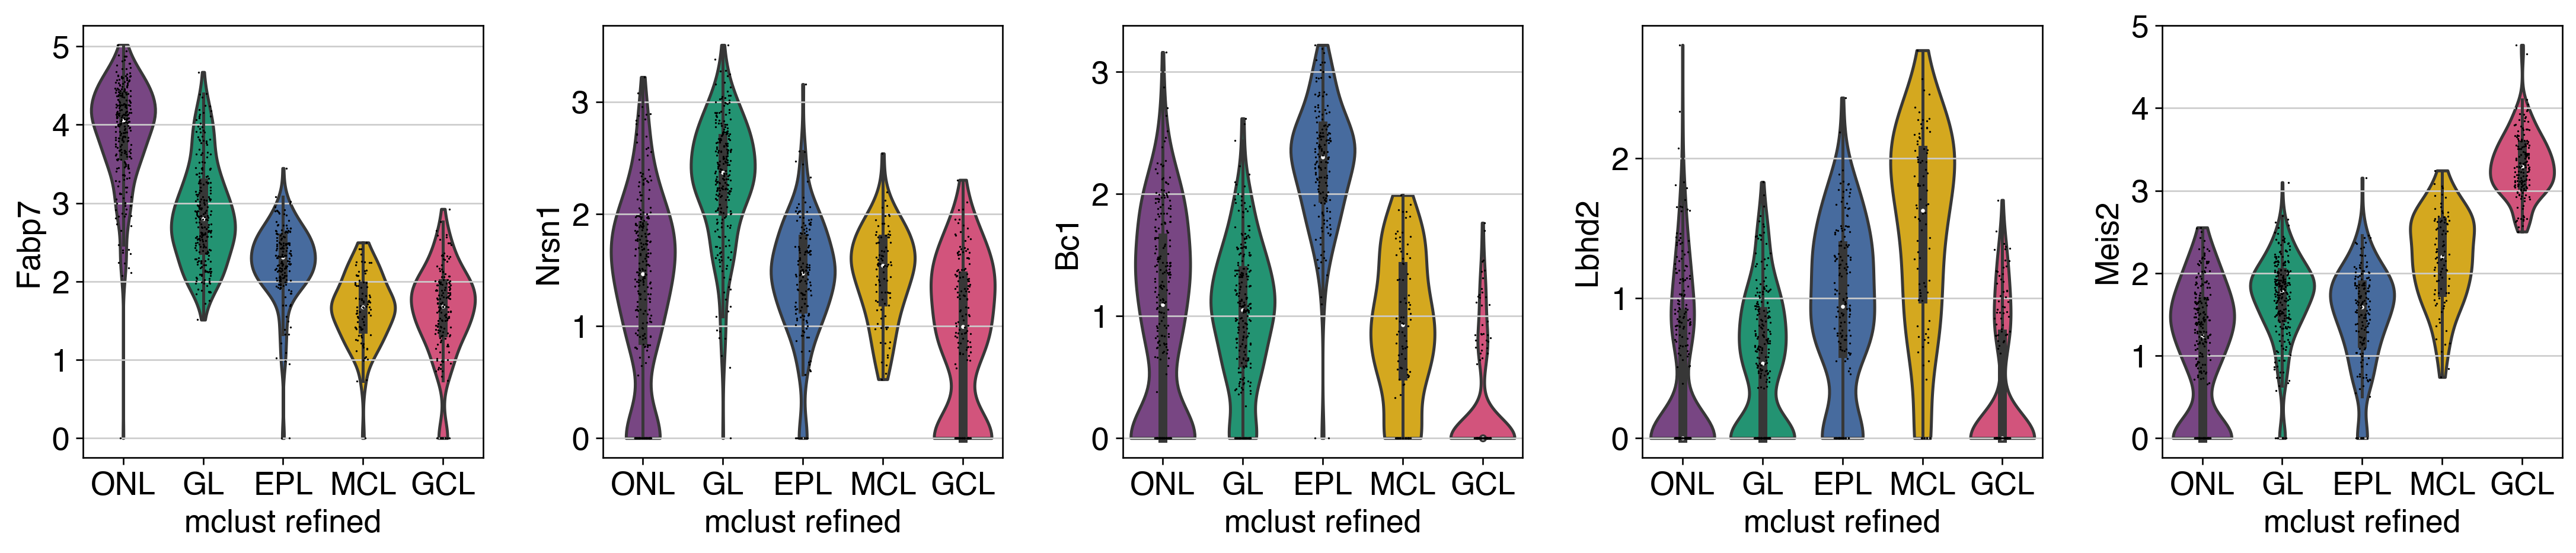

In [6]:
sc.pl.violin(adata, keys=gene_names, groupby="mclust_refined", inner='box',
             save="_makergenes",)

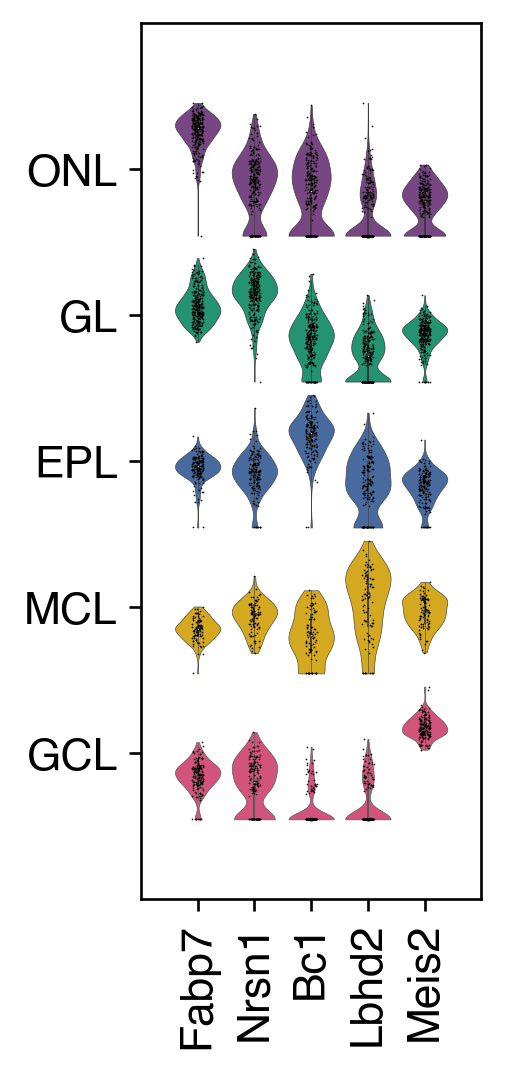

In [7]:
sc.pl.stacked_violin(adata, gene_names, groupby="mclust_refined", 
                     standard_scale='var',
                     stripplot=True, jitter=True, inner='box', size=.5,
                     row_palette=palette,
                     figsize=[3.5, 4.8],
                     save="_makergenes",)

In [8]:
sc.tl.rank_genes_groups(adata, "mclust_refined", gene_names=gene_names)

In [9]:
for cc, gg in zip(adata.obs["mclust_refined"].cat.categories, gene_names):
    ii = adata.obs["mclust_refined"] == cc
    xx = adata[ii][:, gg].X.A.squeeze()
    yy = adata[~ii][:, gg].X.A.squeeze()
    pval = stats.ranksums(xx, yy).pvalue

In [10]:
df_significance = {}
for c1, gg in zip(adata.obs["mclust_refined"].cat.categories, gene_names):
    df_significance[f"{gg} ({c1})"] = {}
    ii = adata.obs["mclust_refined"] == c1
    for c2 in adata.obs["mclust_refined"].cat.categories:
        jj = adata.obs["mclust_refined"] == c2
        xx = adata[ii][:, gg].X.A.squeeze()
        yy = adata[jj][:, gg].X.A.squeeze()
        _, pval = stats.ranksums(xx, yy, alternative="greater")
        df_significance[f"{gg} ({c1})"][c2] = f"{pval:.2E}" if pval < 0.05 else f"{pval:.4f}"
    xx = adata[ii][:, gg].X.A.squeeze()
    yy = adata[~ii][:, gg].X.A.squeeze()
    pval = stats.ranksums(xx, yy, alternative="greater").pvalue
    df_significance[f"{gg} ({c1})"][f"Excluded"] = f"{pval:.2E}"
        # print(f"The gene \"{gg}\" in category \"{c1}\" against \"{c2}\" has pval:{pval:.2E}")

In [11]:
df_significance = pd.DataFrame(df_significance).T
df_significance.to_latex(f"{plot_dir}/table_marker_significance.tex")
df_significance.to_excel(f"{plot_dir}/table_marker_significance.xlsx")
df_significance

/tmp/ipykernel_2302445/1381658510.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_significance.to_latex(f"{plot_dir}/table_marker_significance.tex")


ONL        GL       EPL       MCL       GCL  Excluded
Fabp7 (ONL)    0.5000  3.24E-48  3.16E-60  1.02E-44  4.81E-65  1.38E-98
Nrsn1 (GL)   1.73E-41    0.5000  1.36E-39  7.13E-29  9.47E-53  8.68E-72
Bc1 (EPL)    1.42E-45  1.03E-52    0.5000  5.86E-34  3.93E-52  2.26E-70
Lbhd2 (MCL)  3.58E-23  1.56E-22  1.42E-09    0.5000  4.01E-24  3.18E-25
Meis2 (GCL)  4.25E-67  1.09E-64  8.32E-54  2.91E-35    0.5000  8.28E-87

Wilcoxon ranksum is conducted for the specific gene of corresponding layer in interest compared with other clusters or the entire set excluded the layer in interest. The results shows significant divergence for the expression level (pval $<$ 1E-20).

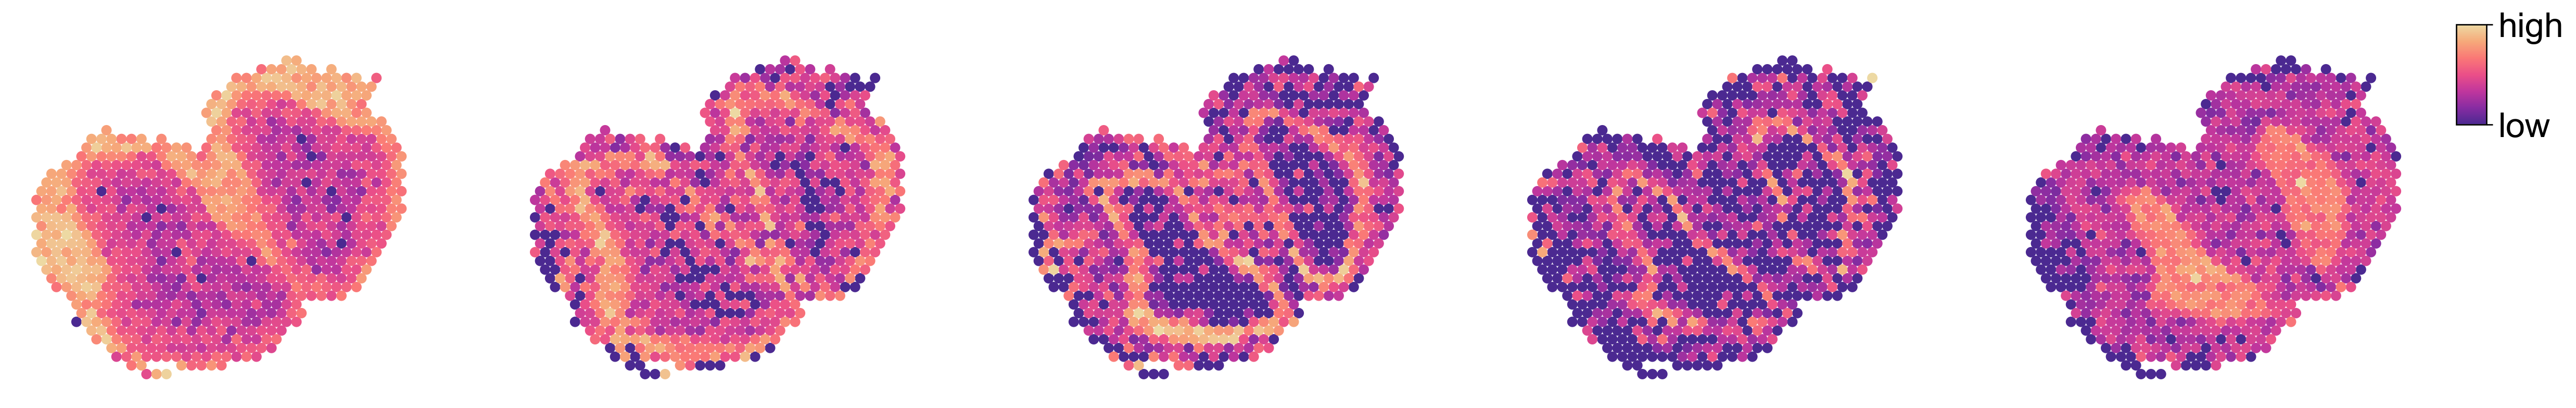

In [12]:
sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf", fontsize=20)
with plt.rc_context():
    fig = sc.pl.spatial(adata, color=gene_names, ncols=5, alpha_img=0.0,
                         title=[''] * 5,
                         color_map=palette_seq, vmin=0,
                         frameon=False, 
                         colorbar_loc=None,
                         img_key="hires", size=1.6,
                         show=False,
                         return_fig=True,
                        )
    cax = plt.axes([0.85, 0.7, 0.01, 0.2])
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=palette_seq), cax=cax, ticks=[0, 1])
    cbar.ax.set_yticklabels(["low", "high"])
    plt.savefig(f"{plot_dir}/show_markergenes.pdf", bbox_inches="tight", dpi=400)

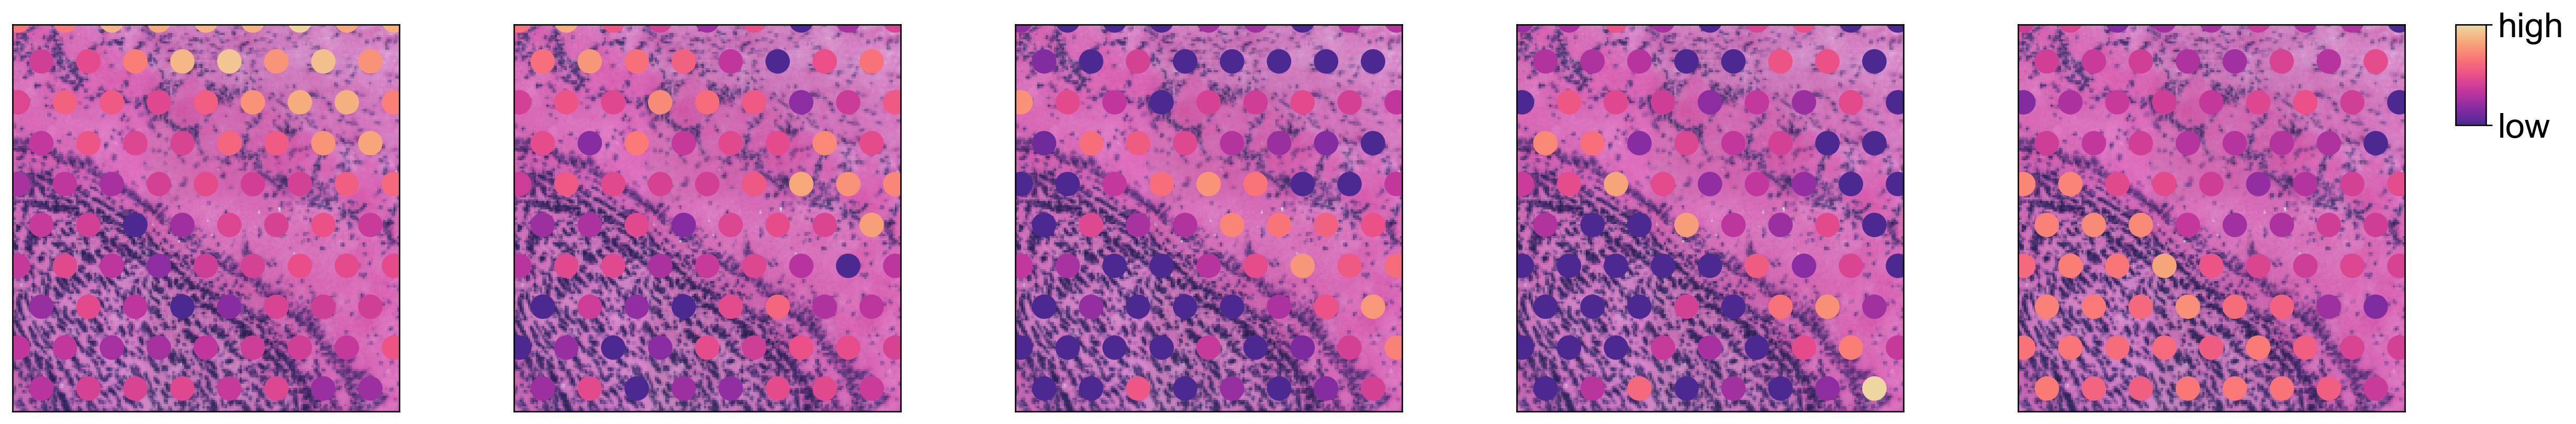

In [13]:
crop = [19200, 22200, 12000, 15000]
with plt.rc_context():
    axes = sc.pl.spatial(adata, color=gene_names,
                         crop_coord=crop, ncols=5,
                         title=[''] * 5,
                         vmin=0,
                         color_map=palette_seq, frameon=True, 
                         colorbar_loc=None,
                         img_key="hires", size=0.8,
                         show=False,)
    for ax in axes:
        _ = ax.set_xlabel("")
        _ = ax.set_ylabel("")
    cax = plt.axes([0.85, 0.7, 0.01, 0.2])
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=palette_seq), cax=cax, ticks=[0, 1])
    cbar.ax.set_yticklabels(["low", "high"])
    plt.savefig(f"{plot_dir}/show_zoomin_markergenes.pdf", bbox_inches="tight", dpi=400)

In [14]:
stfhelper.complete_unseen_expression(adata_sp, gene_names, adata)

Propagating genes...:   0%|          | 0/5 [00:00<?, ?it/s]

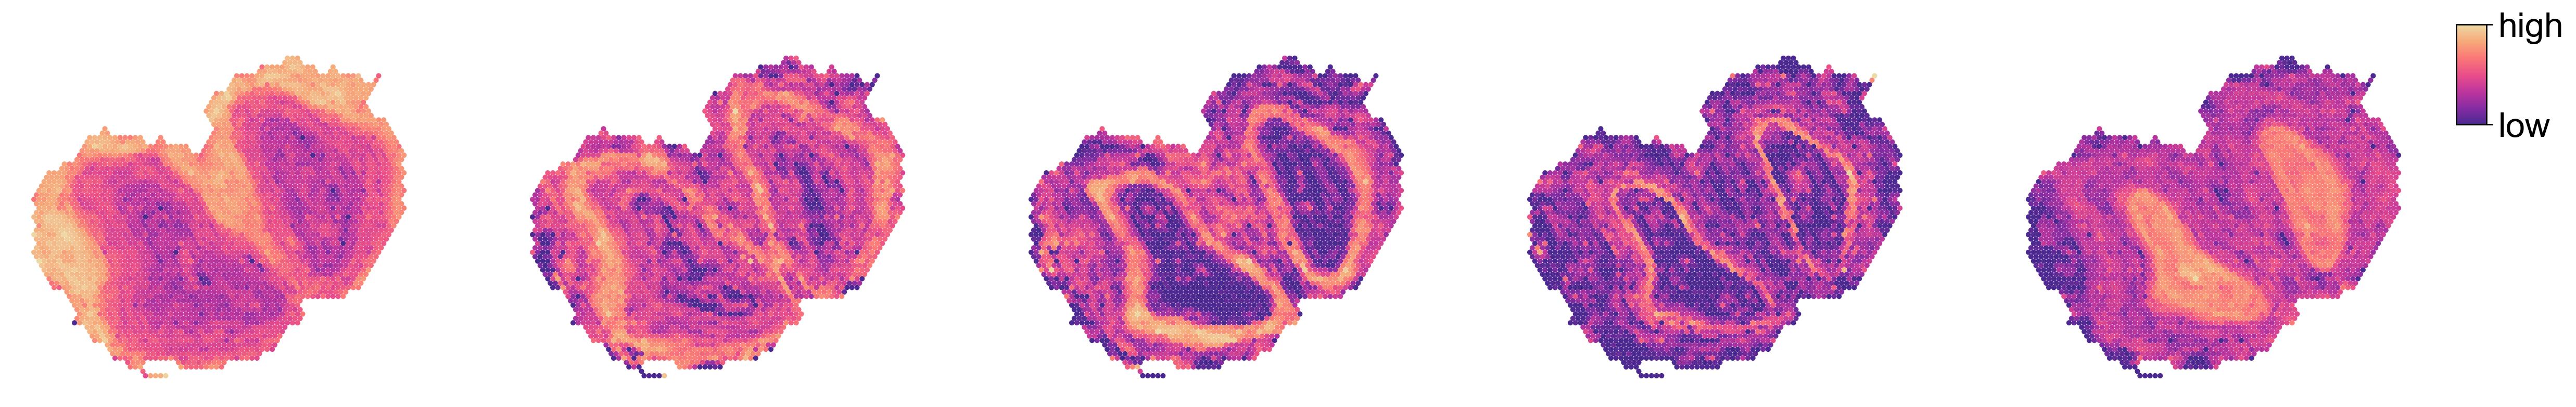

In [15]:
with plt.rc_context():
    sc.pl.spatial(adata_sp, color=list(map(lambda s: s + "_with_padding", gene_names)), size=0.8,
                  color_map=palette_seq, vmin=0,
                  ncols=5, alpha_img=0.0,
                  title=[""] * 5,
                  frameon=False, colorbar_loc=None,
                  img=adata.uns['spatial']['stomic']['images']['hires'],
                  spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
                  scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'],
                  show=False,
                  return_fig=True,
                )
    cax = plt.axes([0.85, 0.7, 0.01, 0.2])
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=palette_seq), cax=cax, ticks=[0, 1])
    cbar.ax.set_yticklabels(["low", "high"])
    plt.savefig(f"{plot_dir}/show_sp_markergenes.pdf", bbox_inches="tight", dpi=400)

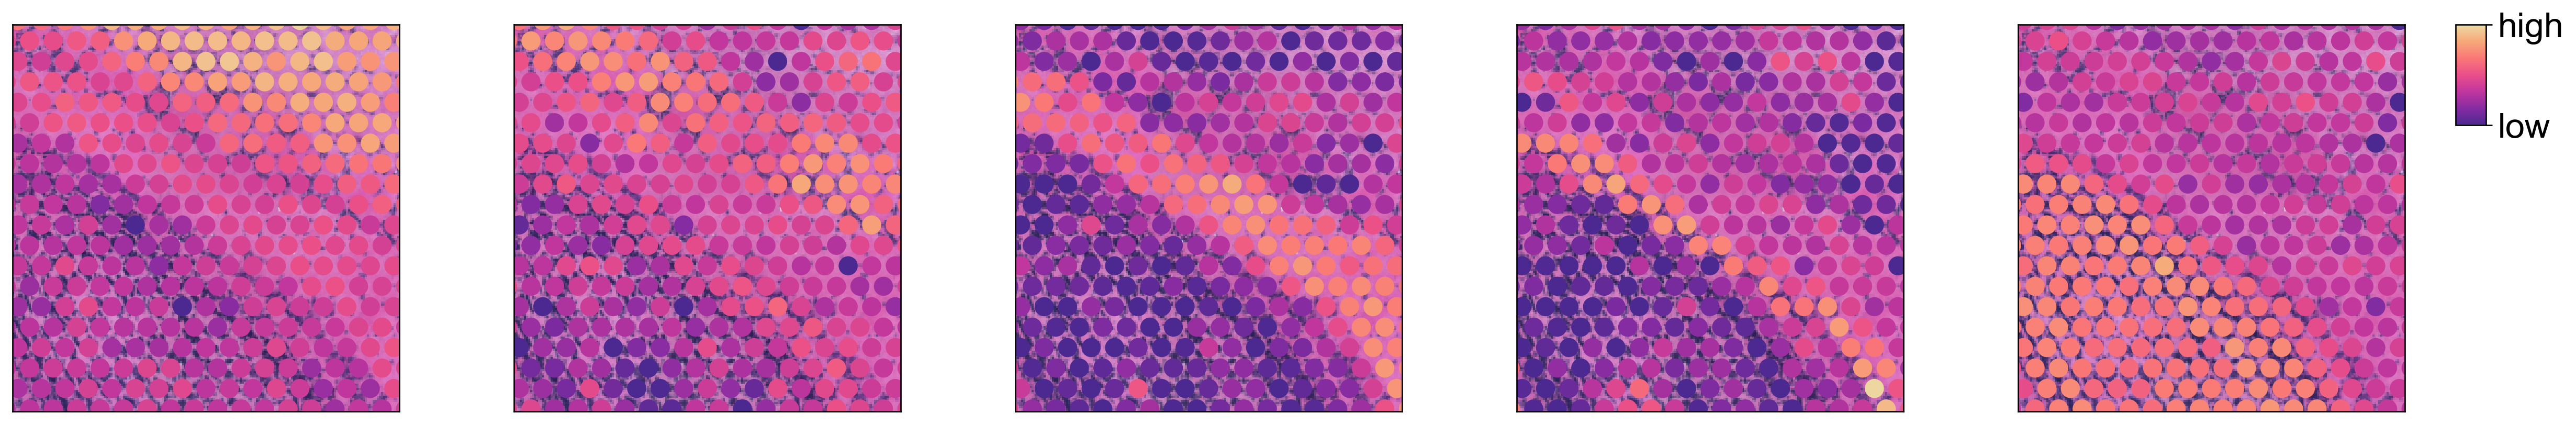

In [16]:
with plt.rc_context():
    axes = sc.pl.spatial(adata_sp, color=list(map(lambda s: s + "_with_padding", gene_names)), size=0.625,
                         color_map=palette_seq, ncols=5,
                         vmin=0,
                         title=[""] * 5,
                         frameon=True, 
                         colorbar_loc=None,
                         crop_coord=crop,
                         img=adata.uns['spatial']['stomic']['images']['hires'],
                         spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
                         scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'],
                         show=False,)
    for ax in axes:
        _ = ax.set_xlabel("")
        _ = ax.set_ylabel("")
    cax = plt.axes([0.85, 0.7, 0.01, 0.2])
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=palette_seq), cax=cax, ticks=[0, 1])
    cbar.ax.set_yticklabels(["low", "high"])
    plt.savefig(f"{plot_dir}/show_sp_zoomin_markergenes.pdf", bbox_inches="tight", dpi=400)